In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA 

In [2]:
data = pd.read_table("2B.tsv")
data.head()

,Customer ID,Gender,Birth Date,Married,Dependents,Number of Dependents,Country,City,Number of Referrals,Tenure in Months,...,Avg Monthly GB Download,Premium Tech Support,Streaming Movies,Streaming Music,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Refunds,Satisfaction Score
0,8779-QRDMV,Male,1946/07/17,No,No,0,United States,Los Angeles,0,1,...,8,No,Yes,No,Month-to-Month,Yes,Bank Withdrawal,39.65,0.00,3
1,7495-OOKFY,Female,1950/11/12,Yes,Yes,1,United States,Los Angeles,1,8,...,17,No,No,No,Month-to-Month,Yes,Credit Card,80.65,0.00,3
2,1658-BYGOY,Male,1953/03/21,No,Yes,3,United States,Los Angeles,0,18,...,52,No,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,45.61,2
3,4598-XLKNJ,Female,1946/03/08,Yes,Yes,1,United States,Inglewood,1,25,...,12,No,Yes,No,Month-to-Month,Yes,Bank Withdrawal,98.50,13.43,2
4,4846-WHAFZ,Female,1944/04/02,Yes,Yes,1,United States,Whittier,1,37,...,14,No,No,No,Month-to-Month,Yes,Bank Withdrawal,76.50,0.00,2


EDA

In [3]:
print(data.isnull().sum()) #terdapat null value di internet type

Customer ID                             0
Gender                                  0
Birth Date                              0
Married                                 0
Dependents                              0
Number of Dependents                    0
Country                                 0
City                                    0
Number of Referrals                     0
Tenure in Months                        0
Avg Monthly Long Distance Charges       0
Internet Service                        0
Internet Type                        1526
Avg Monthly GB Download                 0
Premium Tech Support                    0
Streaming Movies                        0
Streaming Music                         0
Contract                                0
Paperless Billing                       0
Payment Method                          0
Monthly Charge                          0
Total Refunds                           0
Satisfaction Score                      0
dtype: int64


In [4]:
print(data.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Birth Date                         7043 non-null   object 
 3   Married                            7043 non-null   object 
 4   Dependents                         7043 non-null   object 
 5   Number of Dependents               7043 non-null   int64  
 6   Country                            7043 non-null   object 
 7   City                               7043 non-null   object 
 8   Number of Referrals                7043 non-null   int64  
 9   Tenure in Months                   7043 non-null   int64  
 10  Avg Monthly Long Distance Charges  7043 non-null   float64
 11  Internet Service                   7043 non-null   objec

In [5]:
#replacing missing values
data['Internet Type'].fillna('No Service', inplace=True) 

In [6]:
#convert 'Birth Date' 
data['Birth Date'] = pd.to_datetime(data['Birth Date'])
current_date = pd.Timestamp.now() #wktu hri ini

#itung 'Age'
data['Age'] = np.floor((current_date - data['Birth Date']).dt.days / 365).astype(int)

# Drop the 'Birth Date'
data.drop(columns='Birth Date', inplace=True)

#soalnya birth date seems to be much of a hassle kalau ga di summarize

In [7]:
data.nunique()

Customer ID                          7043
Gender                                  2
Married                                 2
Dependents                              2
Number of Dependents                   10
Country                                 1
City                                 1106
Number of Referrals                    12
Tenure in Months                       72
Avg Monthly Long Distance Charges    3584
Internet Service                        2
Internet Type                           4
Avg Monthly GB Download                50
Premium Tech Support                    2
Streaming Movies                        2
Streaming Music                         2
Contract                                3
Paperless Billing                       2
Payment Method                          3
Monthly Charge                       1585
Total Refunds                         500
Satisfaction Score                      5
Age                                    63
dtype: int64

In [8]:
data = data.drop(['City', 'Country', 'Customer ID'], axis=1)
#reason why i dropped this was imo these columns are insignificant for clustering and only make the model too complicated if i keep it.

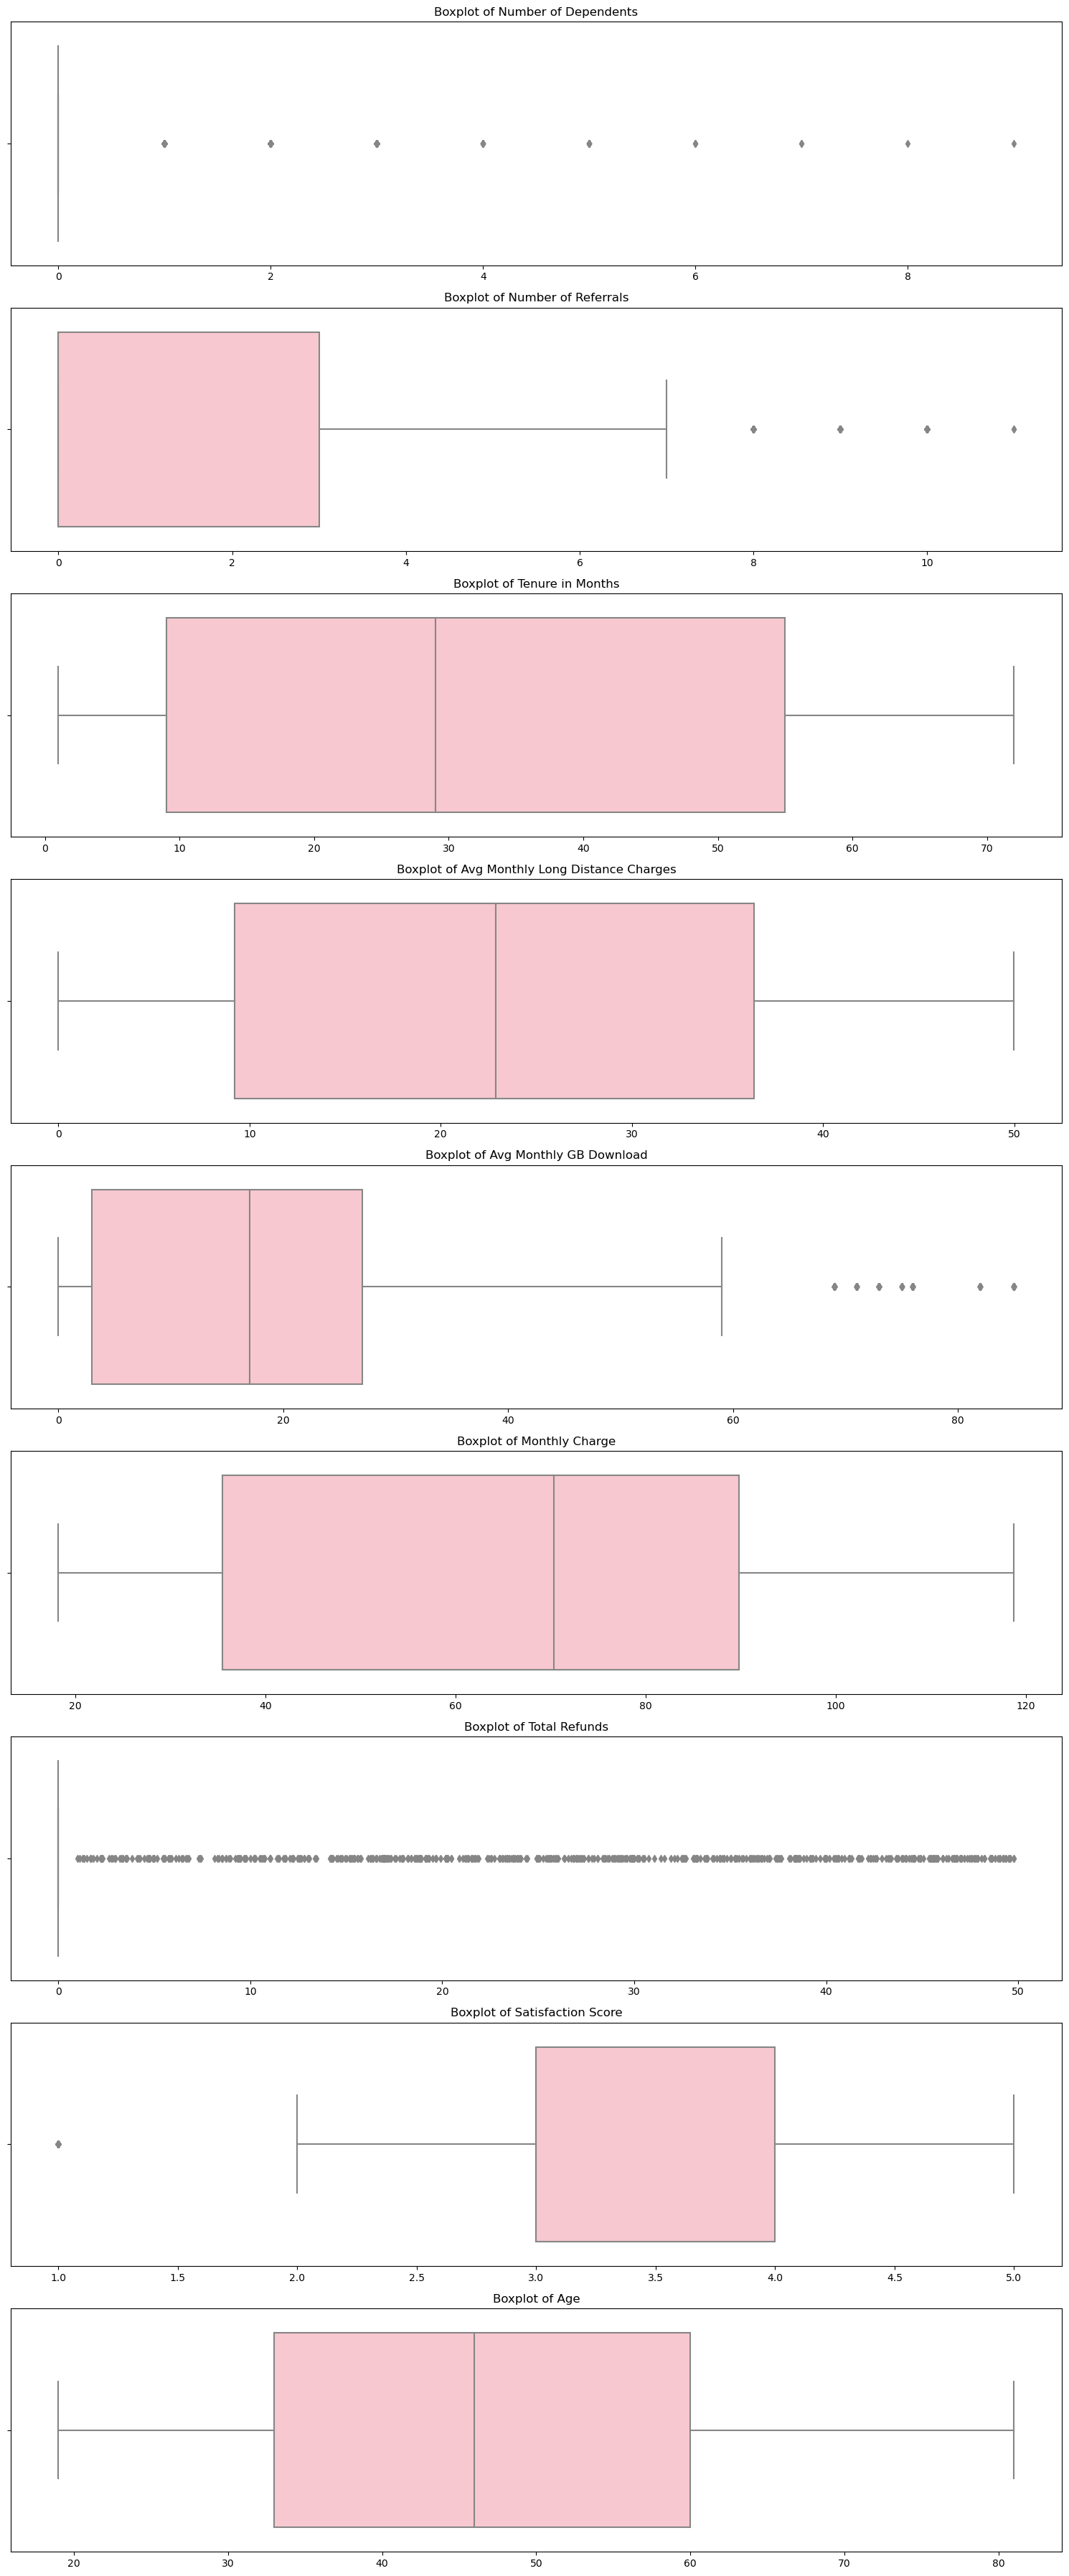

In [9]:
import seaborn as sns

# Select numerical columns only
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Set up the plotting area
plt.figure(figsize=(15, len(numerical_cols) * 4))

# Generate boxplots for each numerical column
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 1, i)
    sns.boxplot(data=data, x=col, color='pink')
    plt.title(f'Boxplot of {col}')
    plt.xlabel('')

plt.tight_layout()
plt.show()

there are some outliers so i'll need to fix it

In [10]:
dependents_count = data['Number of Dependents'].value_counts()
data = data.loc[data['Number of Dependents'] <= 5]

In [11]:
referrals_count = data['Number of Referrals'].value_counts()

#create a new column 'Loyalty' based on the number of referrals, marking 'Loyal' for referrals >= 2
data['Loyalty'] = data['Number of Referrals'].apply(lambda referrals: 'Loyal' if referrals >= 2 else 'Not Loyal')

In [12]:
referrals_count = data['Number of Referrals'].value_counts()

#create a new column 'Loyalty' based on the number of referrals, marking 'Loyal' for referrals >= 2
data['Loyalty'] = data['Number of Referrals'].apply(lambda referrals: 'Loyal' if referrals >= 2 else 'Not Loyal')

In [13]:
#create a new column 'Usage' based on the 'Avg Monthly GB Download' values
data['Usage'] = data['Avg Monthly GB Download'].apply(lambda download: 'Low Usage' if download < 30 else 'High Usage')

In [14]:
#drop semua ini karena udah buat kolom alternatif yang lebih berguna utk encoding
data = data.drop(['Number of Referrals', 'Avg Monthly GB Download'], axis = 1)

kolom total refund masuk ke hal yg wajar klo outliernya banyak krn disebabkan dr human error

check data lagi

In [15]:
data.isnull().sum()

Gender                               0
Married                              0
Dependents                           0
Number of Dependents                 0
Tenure in Months                     0
Avg Monthly Long Distance Charges    0
Internet Service                     0
Internet Type                        0
Premium Tech Support                 0
Streaming Movies                     0
Streaming Music                      0
Contract                             0
Paperless Billing                    0
Payment Method                       0
Monthly Charge                       0
Total Refunds                        0
Satisfaction Score                   0
Age                                  0
Loyalty                              0
Usage                                0
dtype: int64

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7036 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             7036 non-null   object 
 1   Married                            7036 non-null   object 
 2   Dependents                         7036 non-null   object 
 3   Number of Dependents               7036 non-null   int64  
 4   Tenure in Months                   7036 non-null   int64  
 5   Avg Monthly Long Distance Charges  7036 non-null   float64
 6   Internet Service                   7036 non-null   object 
 7   Internet Type                      7036 non-null   object 
 8   Premium Tech Support               7036 non-null   object 
 9   Streaming Movies                   7036 non-null   object 
 10  Streaming Music                    7036 non-null   object 
 11  Contract                           7036 non-null   object 
 1

In [17]:
data.head(10)

,Gender,Married,Dependents,Number of Dependents,Tenure in Months,Avg Monthly Long Distance Charges,Internet Service,Internet Type,Premium Tech Support,Streaming Movies,Streaming Music,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Refunds,Satisfaction Score,Age,Loyalty,Usage
0,Male,No,No,0,1,0.00,Yes,DSL,No,Yes,No,Month-to-Month,Yes,Bank Withdrawal,39.65,0.00,3,78,Not Loyal,Low Usage
1,Female,Yes,Yes,1,8,48.85,Yes,Fiber Optic,No,No,No,Month-to-Month,Yes,Credit Card,80.65,0.00,3,74,Not Loyal,Low Usage
2,Male,No,Yes,3,18,11.33,Yes,Fiber Optic,No,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,45.61,2,71,Not Loyal,High Usage
3,Female,Yes,Yes,1,25,19.76,Yes,Fiber Optic,No,Yes,No,Month-to-Month,Yes,Bank Withdrawal,98.50,13.43,2,78,Not Loyal,Low Usage
4,Female,Yes,Yes,1,37,6.33,Yes,Fiber Optic,No,No,No,Month-to-Month,Yes,Bank Withdrawal,76.50,0.00,2,80,Not Loyal,Low Usage
5,Female,No,Yes,1,27,3.33,Yes,Fiber Optic,No,No,No,Month-to-Month,Yes,Bank Withdrawal,78.05,0.00,1,72,Not Loyal,Low Usage
6,Female,Yes,Yes,2,1,15.28,Yes,Fiber Optic,No,No,No,Month-to-Month,Yes,Mailed Check,70.45,0.00,2,76,Not Loyal,High Usage
7,Male,Yes,No,0,58,0.00,Yes,DSL,No,Yes,No,Month-to-Month,Yes,Bank Withdrawal,45.30,40.95,1,66,Loyal,Low Usage
8,Female,No,Yes,2,15,44.07,Yes,Fiber Optic,No,No,No,Month-to-Month,Yes,Mailed Check,74.45,0.00,2,71,Not Loyal,Low Usage
9,Female,No,Yes,2,7,26.95,Yes,Fiber Optic,No,No,No,Month-to-Month,No,Bank Withdrawal,76.45,11.05,2,78,Not Loyal,Low Usage


In [27]:
#gabungin jadi satu
categoricalcols = [column for column in data.columns if data[column].dtype == 'object']
numericalcols = [column for column in data.columns if data[column].dtype != 'object']
manycategoricals = [column for column in categoricalcols if data[column].nunique() > 2]
minicategoricals = [column for column in categoricalcols if data[column].nunique() <= 2]

In [28]:
# Fit the encoders on the mini-category and many-category columns
mini_encode = OneHotEncoder(drop='first', sparse_output=False)
many_encode = OneHotEncoder(drop=None, sparse_output=False)

# Fit and transform the categorical data
encoded_mini_data = mini_encode.fit_transform(data[minicategoricals])
encoded_many_data = many_encode.fit_transform(data[manycategoricals])

# Retrieve the feature names (column names) after encoding
encoded_mini_cols = mini_encode.get_feature_names_out(minicategoricals)
encoded_many_cols = many_encode.get_feature_names_out(manycategoricals)

# Convert the encoded data into DataFrames with corresponding column names
minidatas = pd.DataFrame(encoded_mini_data, columns=encoded_mini_cols)
manydatas = pd.DataFrame(encoded_many_data, columns=encoded_many_cols)

In [34]:
scaler = MinMaxScaler()

#apply Min-Max scaling to numerical columns
scaled_values = scaler.fit_transform(data[numericalcols])
scaled_dataframe = pd.DataFrame(scaled_values, columns=numericalcols)

#combine scaled numerical data with encoded categorical data
cleaned_df = pd.concat([scaled_dataframe, manydatas, minidatas], axis=1)

#inisialisasi ulang
data = cleaned_df.copy()

#display the first few rows of the cleaned dataframe
data.head()


,Number of Dependents,Tenure in Months,Avg Monthly Long Distance Charges,Monthly Charge,Total Refunds,Satisfaction Score,Age,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic,...,Gender_Male,Married_Yes,Dependents_Yes,Internet Service_Yes,Premium Tech Support_Yes,Streaming Movies_Yes,Streaming Music_Yes,Paperless Billing_Yes,Loyalty_Not Loyal,Usage_Low Usage
0,0.0,0.000000,0.000000,0.212935,0.000000,0.50,0.951613,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
1,0.2,0.098592,0.977195,0.620896,0.000000,0.50,0.887097,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
2,0.6,0.239437,0.226645,0.768159,0.916047,0.25,0.838710,0.0,0.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
3,0.2,0.338028,0.395279,0.798507,0.269733,0.25,0.951613,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
4,0.2,0.507042,0.126625,0.579602,0.000000,0.25,0.983871,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0


MODELLING

In [41]:
pca = PCA(n_components=2, random_state=24)  
df_pca = pca.fit_transform(cleaned_df)

/Users/shyraalexandria/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shyraalexandria/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shyraalexandria/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shyraalexandria/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The defa

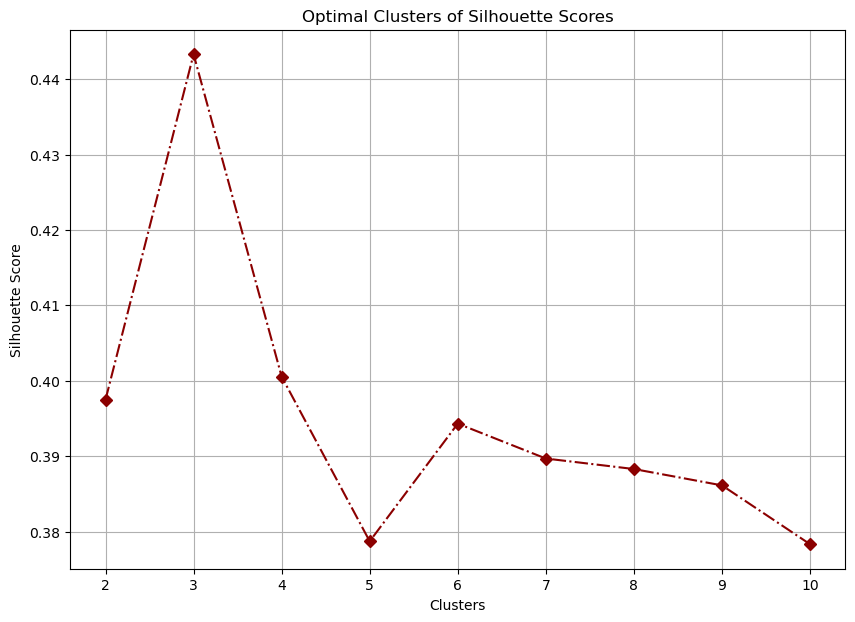

In [ ]:
cluster_silhouette_scores = []

for num_clusters in range(2, 11): 
    kmeans_model = KMeans(n_clusters=num_clusters, random_state=22)  
    cluster_labels = kmeans_model.fit_predict(df_pca)  
    silhouette_avg_score = silhouette_score(df_pca, cluster_labels)  
    cluster_silhouette_scores.append(silhouette_avg_score)  

# Plot the silhouette scores for each number of clusters
plt.figure(figsize=(10, 7)) 
plt.plot(range(2, 11), cluster_silhouette_scores, marker='D', linestyle='-.', color='darkred')  
plt.title('Optimal Clusters Based on Silhouette Scores') 
plt.xlabel('Number of Clusters')  
plt.ylabel('Silhouette Score')  
plt.grid()  
plt.show()

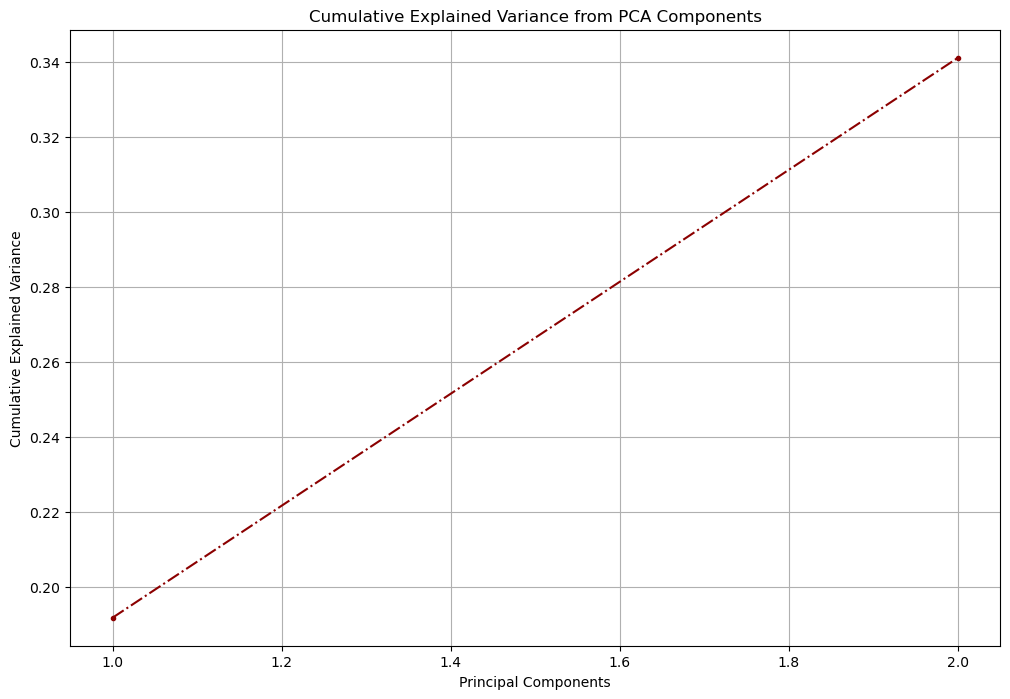

In [49]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

# Plot the cumulative explained variance with updated figure size
plt.figure(figsize=(12, 8)) 
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='.', linestyle='-.', color='darkred')
plt.title('Cumulative Explained Variance from PCA Components')
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


/Users/shyraalexandria/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shyraalexandria/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shyraalexandria/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shyraalexandria/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The defa

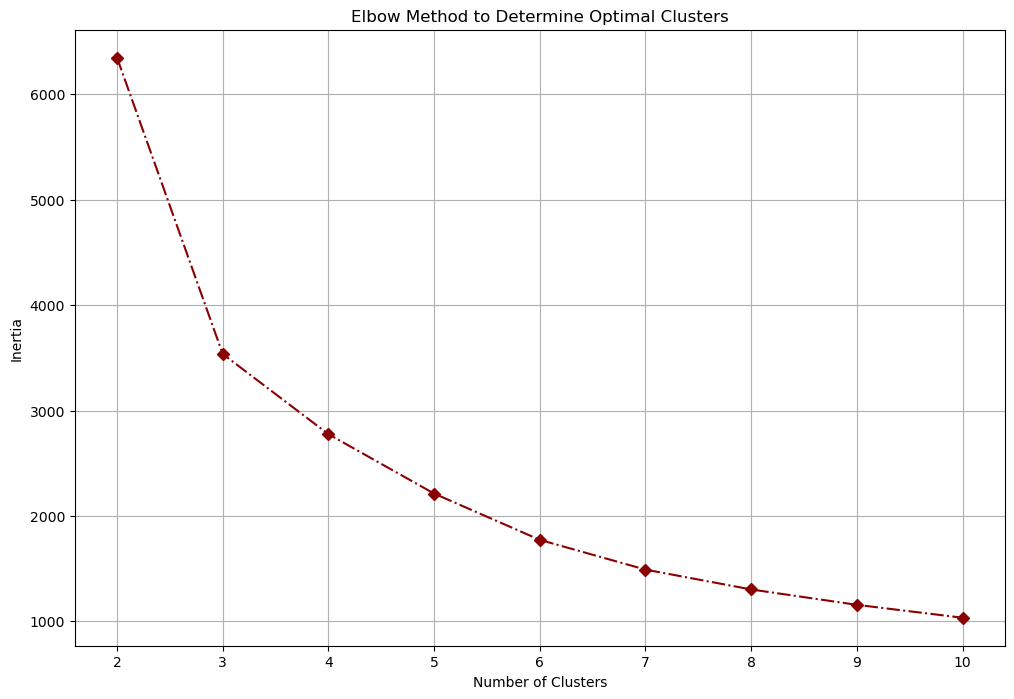

In [50]:
cluster_count_range = range(2, 11)
inertia_scores = []

for n_clusters in cluster_count_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df_pca) 
    inertia_scores.append(kmeans.inertia_)  

# Plot the results from the Elbow Method
plt.figure(figsize=(12, 8))  # Increased figure size
plt.plot(cluster_count_range, inertia_scores, marker='D', linestyle='-.', color='darkred')  
plt.title('Elbow Method to Determine Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


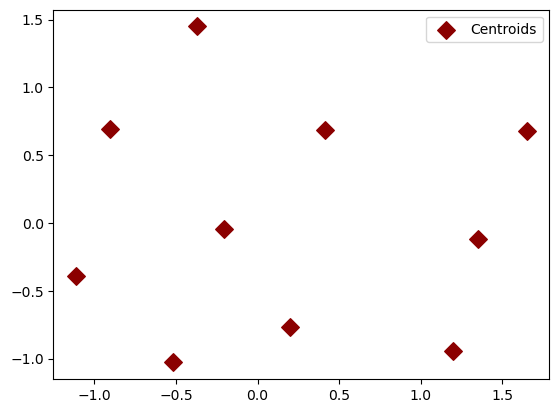

In [70]:
# Plot the cluster centers on the PCA plot
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=80, c='darkred', marker='D', label='Centroids')
plt.legend()
plt.show()


I've decided to use 3 clusters after evaluating the scores

/Users/shyraalexandria/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


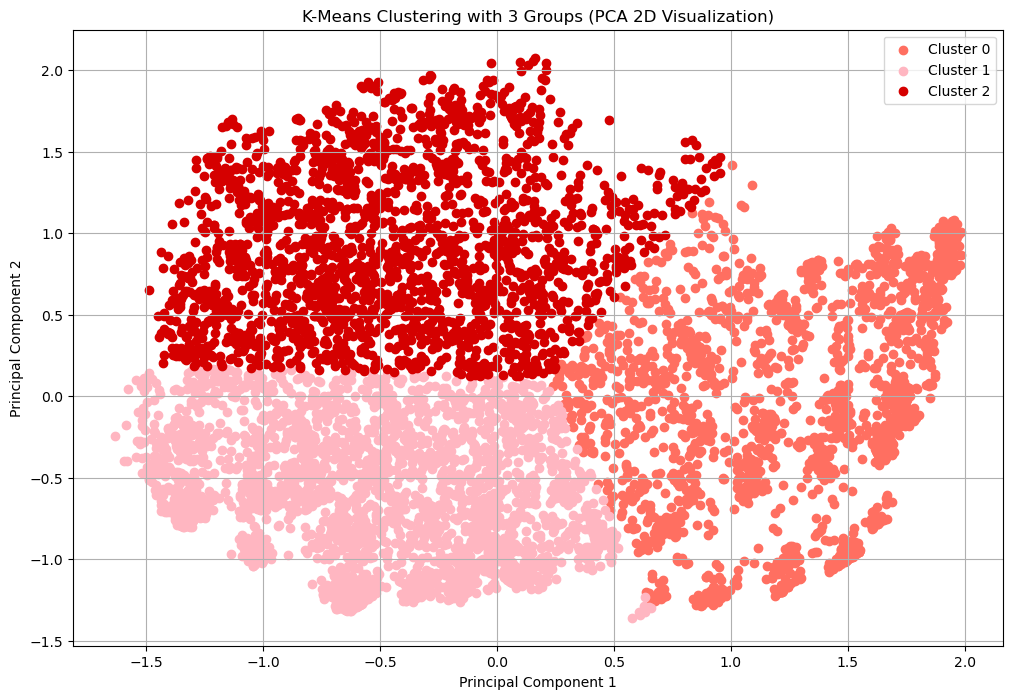

In [54]:
# Set the number of clusters to 3
num_clusters = 3
kmeans_model = KMeans(n_clusters=num_clusters, random_state=52)  # Changed random_state

# Assign cluster labels to the DataFrame
data['Cluster_Label'] = kmeans_model.fit_predict(df_pca)

# Assign the principal components to new columns in the DataFrame
data['Principal_Component_1'] = df_pca[:, 0]
data['Principal_Component_2'] = df_pca[:, 1]

# Define custom colors for each cluster
cluster_colors = ['#FF6F61', '#FFB6C1', '#D50000']  # Example: Tomato, SteelBlue, LimeGreen

# Plot the clusters in a 2D space with custom colors
plt.figure(figsize=(12, 8))  # Changed figsize
for cluster_id in range(num_clusters):
    cluster_points = data[data['Cluster_Label'] == cluster_id]
    plt.scatter(cluster_points['Principal_Component_1'], cluster_points['Principal_Component_2'], 
                label=f'Cluster {cluster_id}', color=cluster_colors[cluster_id])

# Add plot titles and labels
plt.title('K-Means Clustering with 3 Groups (PCA 2D Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()


In [62]:
for cluster in range(n_clusters):
    print(f"Cluster {cluster} Feature Statistics:")
    print(data[data['Cluster_Label'] == cluster].describe())

Cluster 0 Feature Statistics:
       Number of Dependents  Tenure in Months  \
count           1987.000000       1987.000000   
mean               0.142929          0.404694   
std                0.217521          0.332510   
min                0.000000          0.000000   
25%                0.000000          0.098592   
50%                0.000000          0.338028   
75%                0.200000          0.690141   
max                1.000000          1.000000   

       Avg Monthly Long Distance Charges  Monthly Charge  Total Refunds  \
count                        1987.000000     1987.000000    1987.000000   
mean                            0.462119        0.096838       0.035510   
std                             0.300076        0.141616       0.147871   
min                             0.000000        0.000000       0.000000   
25%                             0.200740        0.015920       0.000000   
50%                             0.460892        0.022388       0.000000   
75%

In [59]:
silhouette_avg_score = silhouette_score(df_pca, data['Cluster_Label'])
print(f"Silhouette Score 3 clusters: {silhouette_avg_score}")

Silhouette Score 3 clusters: 0.443413401560748


the score looks good

In [60]:
# Summarize the characteristics of each cluster by calculating the mean
cluster_summary = data.groupby('Cluster_Label').mean()

# Display the summary of the clusters
print("Cluster Characteristics Analysis: ")
print(cluster_summary)

Cluster Characteristics Analysis: 
               Number of Dependents  Tenure in Months  \
Cluster_Label                                           
0                          0.142929          0.404694   
1                          0.031321          0.253026   
2                          0.128186          0.731818   

               Avg Monthly Long Distance Charges  Monthly Charge  \
Cluster_Label                                                      
0                                       0.462119        0.096838   
1                                       0.459066        0.562362   
2                                       0.457102        0.667325   

               Total Refunds  Satisfaction Score       Age  \
Cluster_Label                                                
0                   0.035510            0.692250  0.397446   
1                   0.035099            0.427734  0.480060   
2                   0.048952            0.620000  0.442296   

               Internet Typ